# PART2 DCGAN 
- Latent Vector Size (nz): 100
- Optimizer: Adam
- Generator and Discriminator: 5 layers each
- Generator Feature Maps: 64
- Discriminator Feature Maps: 64

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters
batch_size = 128
image_size = 64 
nc = 3  # RBG
nz = 100  # Latent 
ngf = 64  # Generator feature map 
ndf = 64  # Discriminator feature map 
num_epochs = 10
lr = 0.0002
beta1 = 0.5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_root = './img_align_celeba'
#data_root = "DCGAN_testB"
dataset = dset.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)

netG = Generator().to(device)
netD = Discriminator().to(device)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

G_losses, D_losses, img_list = [], [], []
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_data = data[0].to(device)
        b_size = real_data.size(0)
        label = torch.full((b_size,), 1, device=device, dtype=torch.float)  # Ensure label is float
        output = netD(real_data)
        errD_real = criterion(output, label)
        errD_real.backward()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_data = netG(noise)
        label.fill_(0)
        label = label.float()  
        output = netD(fake_data.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        netG.zero_grad()
        label.fill_(1)
        label = label.float()  
        output = netD(fake_data)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        if i % 50 == 0:
            print(f'[Epoch {epoch}/{num_epochs}] [Step {i}/{len(dataloader)}] D Loss: {errD_real + errD_fake:.4f}, G Loss: {errG:.4f}')

        G_losses.append(errG.item())
        D_losses.append((errD_real + errD_fake).item())

        if epoch == num_epochs - 1 and i == len(dataloader) - 1:
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))


[Epoch 0/10] [Step 0/1583] D Loss: 1.6179, G Loss: 5.5790
[Epoch 0/10] [Step 50/1583] D Loss: 0.1121, G Loss: 25.6544
[Epoch 0/10] [Step 100/1583] D Loss: 1.6677, G Loss: 18.0193
[Epoch 0/10] [Step 150/1583] D Loss: 0.9722, G Loss: 5.2618
[Epoch 0/10] [Step 200/1583] D Loss: 0.5189, G Loss: 4.7275
[Epoch 0/10] [Step 250/1583] D Loss: 1.1310, G Loss: 3.1192
[Epoch 0/10] [Step 300/1583] D Loss: 0.3846, G Loss: 5.4085
[Epoch 0/10] [Step 350/1583] D Loss: 0.9940, G Loss: 5.3691
[Epoch 0/10] [Step 400/1583] D Loss: 0.5378, G Loss: 4.2655
[Epoch 0/10] [Step 450/1583] D Loss: 0.4721, G Loss: 3.9476
[Epoch 0/10] [Step 500/1583] D Loss: 0.2510, G Loss: 4.9201
[Epoch 0/10] [Step 550/1583] D Loss: 0.6902, G Loss: 7.4749
[Epoch 0/10] [Step 600/1583] D Loss: 0.6318, G Loss: 6.0902
[Epoch 0/10] [Step 650/1583] D Loss: 0.5308, G Loss: 5.9282
[Epoch 0/10] [Step 700/1583] D Loss: 0.7809, G Loss: 7.1051
[Epoch 0/10] [Step 750/1583] D Loss: 0.3868, G Loss: 5.5758
[Epoch 0/10] [Step 800/1583] D Loss: 0.70

In [3]:
# Modified Generator
fixed_noise = torch.randn(64, 256, 1, 1, device=device)
class ModifiedGenerator(nn.Module):
    def __init__(self):
        super(ModifiedGenerator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(256, ngf * 16, 4, 1, 0, bias=False),  # Increased
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class ModifiedDiscriminator(nn.Module):
    def __init__(self):
        super(ModifiedDiscriminator, self).__init__()
        self.main = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)),
            nn.Sigmoid()
        )

    def forward(self, input):
        b_size = input.size(0)
        #flatten the output
        return self.main(input).view(b_size, -1).mean(dim=1)

netG_mod = ModifiedGenerator().to(device)
netD_mod = ModifiedDiscriminator().to(device)

netG_mod.apply(weights_init)
netD_mod.apply(weights_init)

optimizerD_mod = optim.RMSprop(netD_mod.parameters(), lr=0.00005)
optimizerG_mod = optim.RMSprop(netG_mod.parameters(), lr=0.00005)

G_losses_mod, D_losses_mod, img_list_mod = [], [], []
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD_mod.zero_grad()
        real_data = data[0].to(device)
        b_size = real_data.size(0)

        label = torch.full((b_size,), 1, device=device, dtype=torch.float)
        output = netD_mod(real_data)
        errD_real = criterion(output, label)
        errD_real.backward()

        noise = torch.randn(b_size, 256, 1, 1, device=device)
        fake_data = netG_mod(noise)

        label.fill_(0)
        label = label.float()
        output = netD_mod(fake_data.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD_mod.step()

        netG_mod.zero_grad()
        label.fill_(1)
        label = label.float()
        output = netD_mod(fake_data)
        errG_mod = criterion(output, label)
        errG_mod.backward()
        optimizerG_mod.step()

        if i % 50 == 0:
            print(f'[Epoch {epoch}/{num_epochs}] [Step {i}/{len(dataloader)}] D Loss: {errD_real + errD_fake:.4f}, G Loss: {errG_mod:.4f}')

        G_losses_mod.append(errG_mod.item())
        D_losses_mod.append((errD_real + errD_fake).item())

        if epoch == num_epochs - 1 and i == len(dataloader) - 1:
            with torch.no_grad():
                fake = netG_mod(fixed_noise).detach().cpu()
            img_list_mod.append(vutils.make_grid(fake, padding=2, normalize=True))

[Epoch 0/10] [Step 0/1583] D Loss: 1.3768, G Loss: 3.2610
[Epoch 0/10] [Step 50/1583] D Loss: 0.1307, G Loss: 2.1236
[Epoch 0/10] [Step 100/1583] D Loss: 0.1296, G Loss: 2.1272
[Epoch 0/10] [Step 150/1583] D Loss: 0.1282, G Loss: 2.1349
[Epoch 0/10] [Step 200/1583] D Loss: 0.0131, G Loss: 6.3302
[Epoch 0/10] [Step 250/1583] D Loss: 0.0058, G Loss: 6.2808
[Epoch 0/10] [Step 300/1583] D Loss: 0.0040, G Loss: 6.8764
[Epoch 0/10] [Step 350/1583] D Loss: 0.0028, G Loss: 8.7298
[Epoch 0/10] [Step 400/1583] D Loss: 0.0019, G Loss: 9.3127
[Epoch 0/10] [Step 450/1583] D Loss: 0.0010, G Loss: 8.4830
[Epoch 0/10] [Step 500/1583] D Loss: 0.0010, G Loss: 9.2831
[Epoch 0/10] [Step 550/1583] D Loss: 0.0007, G Loss: 9.5444
[Epoch 0/10] [Step 600/1583] D Loss: 0.0005, G Loss: 9.5396
[Epoch 0/10] [Step 650/1583] D Loss: 0.0004, G Loss: 9.7551
[Epoch 0/10] [Step 700/1583] D Loss: 0.0002, G Loss: 10.0637
[Epoch 0/10] [Step 750/1583] D Loss: 0.0003, G Loss: 9.3093
[Epoch 0/10] [Step 800/1583] D Loss: 0.000

# Discriminator Output Shape Mismatch:
The Discriminator was producing a 4x4 grid, leading to a size mismatch during loss calculation with the labels. This was resolved by reshaping the Discriminator output using .view(b_size, -1).mean(dim=1) to return a single scalar value per image.

# Generator Input Size Mismatch:
While generating images, a size mismatch occurred between the Generator's expected input of 256 channels (after adjusting the latent vector size) and the actual input of 100 channels. We corrected this by updating the fixed_noise initialization to match the new latent vector size, using torch.randn(64, 256, 1, 1).

# Loss Fluctuations:
After fixing the shape mismatches, both the Generator and Discriminator losses started to converge. We made sure to monitor and visualize the training process to track both losses effectively.

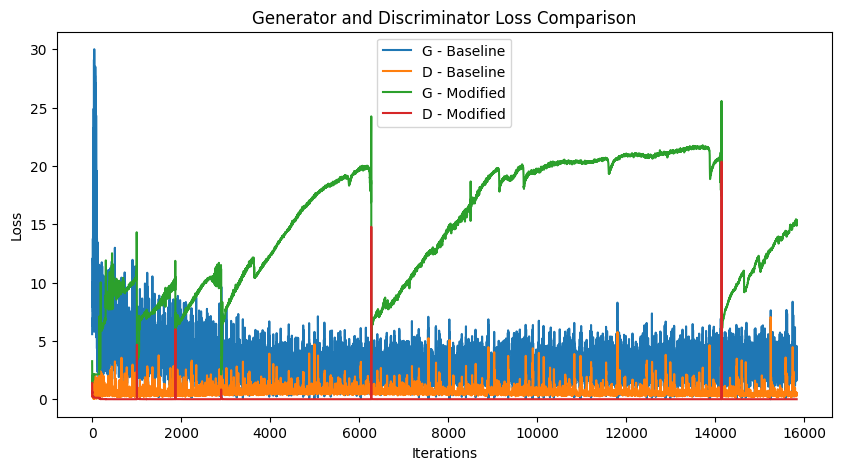

In [4]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss Comparison")
plt.plot(G_losses, label="G - Baseline")
plt.plot(D_losses, label="D - Baseline")
plt.plot(G_losses_mod, label="G - Modified")
plt.plot(D_losses_mod, label="D - Modified")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

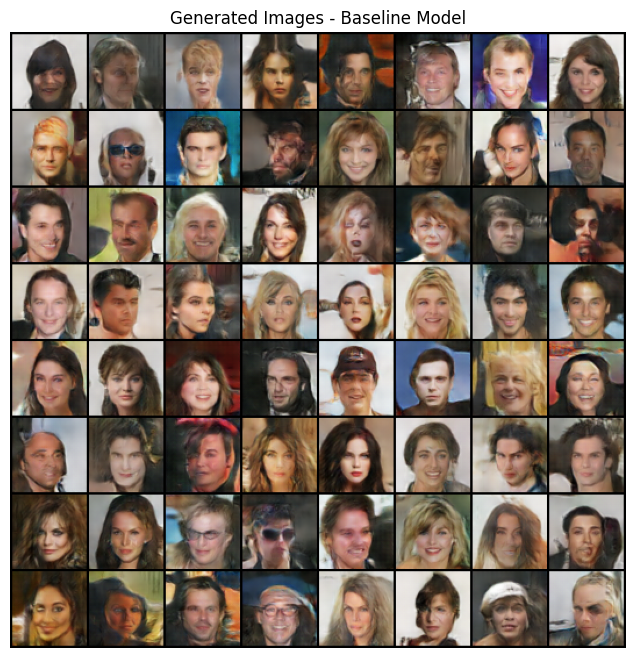

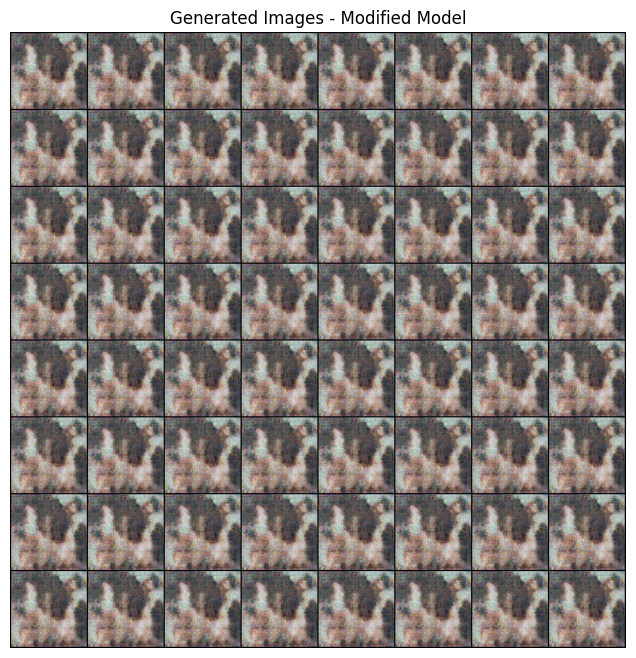

In [5]:
#baseline images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images - Baseline Model")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()

#modified images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images - Modified Model")
plt.imshow(np.transpose(img_list_mod[-1], (1, 2, 0)))
plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils

# Hyperparameters
num_epochs = 20
batch_size = 128
image_size = 64
nz = 128  # Latent vector size reduced from 256 to 128
ngf = 64  # Generator feature map size
ndf = 64  # Discriminator feature map size
lr = 0.0001  # Reduced learning rate from 0.00005 to 0.0001
beta1 = 0.5  # Beta1 for Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Label smoothing: Use 0.9 for real labels instead of 1
real_label = 0.9
fake_label = 0.0

# Generator architecture
class ImprovedGenerator(nn.Module):
    def __init__(self):
        super(ImprovedGenerator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator architecture
class ImprovedDiscriminator(nn.Module):
    def __init__(self):
        super(ImprovedDiscriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        b_size = input.size(0)  # Get batch size
        # Flatten the 4x4 grid and reduce it to a scalar per image
        return self.main(input).view(b_size, -1).mean(dim=1)

# Initialize generator and discriminator
netG = ImprovedGenerator().to(device)
netD = ImprovedDiscriminator().to(device)

# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Add noise to inputs for regularization
def add_noise(inputs, mean=0, stddev=0.1):
    noise = torch.randn_like(inputs) * stddev
    return inputs + noise

# Training loop
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Training with real data
        netD.zero_grad()
        real_data = data[0].to(device)
        b_size = real_data.size(0)
        label = torch.full((b_size,), real_label, device=device, dtype=torch.float)
        output = netD(add_noise(real_data))  # Gaussian noise to real images
        errD_real = criterion(output, label)
        errD_real.backward()

        # Training with fake data
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_data = netG(noise)
        label.fill_(fake_label)
        output = netD(add_noise(fake_data.detach()))  # Gaussian noise to fake images
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        label.fill_(real_label)  # Label smoothing applied here 0.9 not 1
        output = netD(fake_data)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        # Print loss stats every few iterations
        if i % 50 == 0:
            print(f'[Epoch {epoch}/{num_epochs}] [Step {i}/{len(dataloader)}] D Loss: {errD_real + errD_fake:.4f}, G Loss: {errG:.4f}')


[Epoch 0/20] [Step 0/1583] D Loss: 1.8066, G Loss: 0.6213
[Epoch 0/20] [Step 50/1583] D Loss: 0.4554, G Loss: 1.0371
[Epoch 0/20] [Step 100/1583] D Loss: 0.3460, G Loss: 0.7534
[Epoch 0/20] [Step 150/1583] D Loss: 0.3572, G Loss: 0.6220
[Epoch 0/20] [Step 200/1583] D Loss: 0.3780, G Loss: 1.0293
[Epoch 0/20] [Step 250/1583] D Loss: 0.3359, G Loss: 1.3214
[Epoch 0/20] [Step 300/1583] D Loss: 0.3331, G Loss: 0.9764
[Epoch 0/20] [Step 350/1583] D Loss: 0.3357, G Loss: 0.9712
[Epoch 0/20] [Step 400/1583] D Loss: 0.3321, G Loss: 0.9687
[Epoch 0/20] [Step 450/1583] D Loss: 0.3364, G Loss: 0.9680
[Epoch 0/20] [Step 500/1583] D Loss: 0.3303, G Loss: 0.9675
[Epoch 0/20] [Step 550/1583] D Loss: 0.3439, G Loss: 0.9670
[Epoch 0/20] [Step 600/1583] D Loss: 0.3291, G Loss: 0.9666
[Epoch 0/20] [Step 650/1583] D Loss: 0.3284, G Loss: 0.9664
[Epoch 0/20] [Step 700/1583] D Loss: 0.3339, G Loss: 0.9659
[Epoch 0/20] [Step 750/1583] D Loss: 0.3276, G Loss: 0.9659
[Epoch 0/20] [Step 800/1583] D Loss: 0.3299

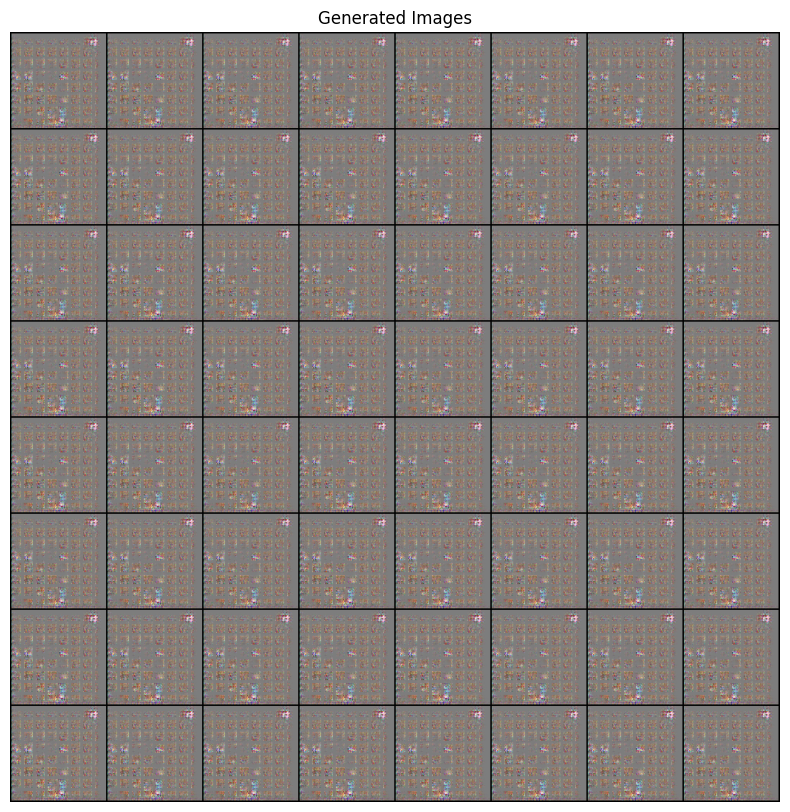

In [7]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt

netG.eval()

def generate_images(num_images, latent_vector_size, save_path=None):
    with torch.no_grad(): 
        noise = torch.randn(num_images, latent_vector_size, 1, 1, device=device)
        
        fake_images = netG(noise)

        fake_images = (fake_images + 1) / 2.0  # Tanh to [0, 1]

        grid = vutils.make_grid(fake_images, nrow=8, padding=2, normalize=True)
        
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.title("Generated Images")
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        
        if save_path:
            plt.savefig(save_path) 
        plt.show()

num_images_to_generate = 64
generate_images(num_images_to_generate, nz)
